In [1]:
import matplotlib
import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
color = sb.color_palette()

%matplotlib inline
PROPERTIES = '../data/properties_2016.csv'
TRAIN = '../data/train_2016_v2.csv'
SAMPLE = '../data/sample_submission.csv' 

df = pd.read_csv(PROPERTIES, low_memory=False)
print ("Shape Of Properties: ",df.shape)

('Shape Of Properties: ', (2985217, 58))


In [2]:
train = pd.read_csv(TRAIN, parse_dates=["transactiondate"], low_memory=False)
print ("Shape Of Train: ",train.shape)

('Shape Of Train: ', (90275, 3))


We have read data from properties to pandas dataframe.

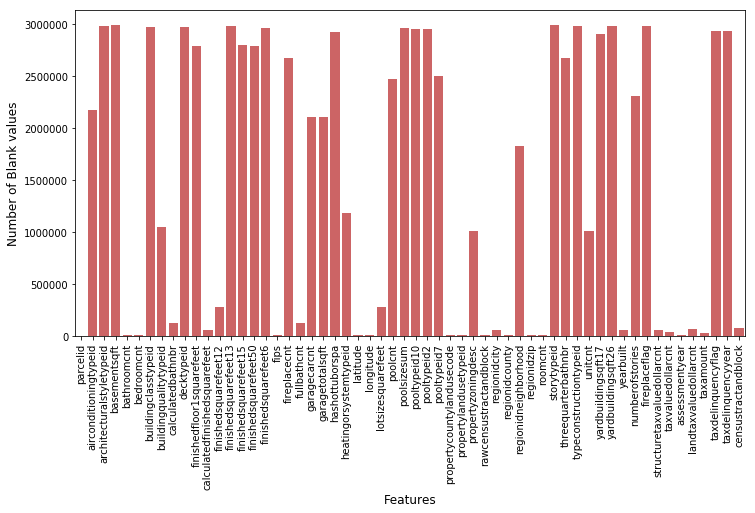

In [3]:
blank_counts = df.isnull().sum(axis=0).reset_index()
plt.figure(figsize=(12,6))
sb.barplot(blank_counts['index'], blank_counts[0], alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Number of Blank values', fontsize=12)
plt.show()
del blank_counts

Bar plot showing the count of null values in different columns. We can see that some of the
columns like architecturalstyletypeid have more than 90% of null values. Columns with too many
null values will be delted later.

In [4]:
train = pd.merge(train, df, on='parcelid', how='left')

In [5]:
missing_df = train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / train.shape[0]
no_values = missing_df.ix[missing_df['missing_ratio']>0.999]
train = train.drop(list(no_values.column_name.values), axis=1)
del missing_df

Finding columns which are having more than 99% of blank values.
I have deleted columns with more than 99% blank values.

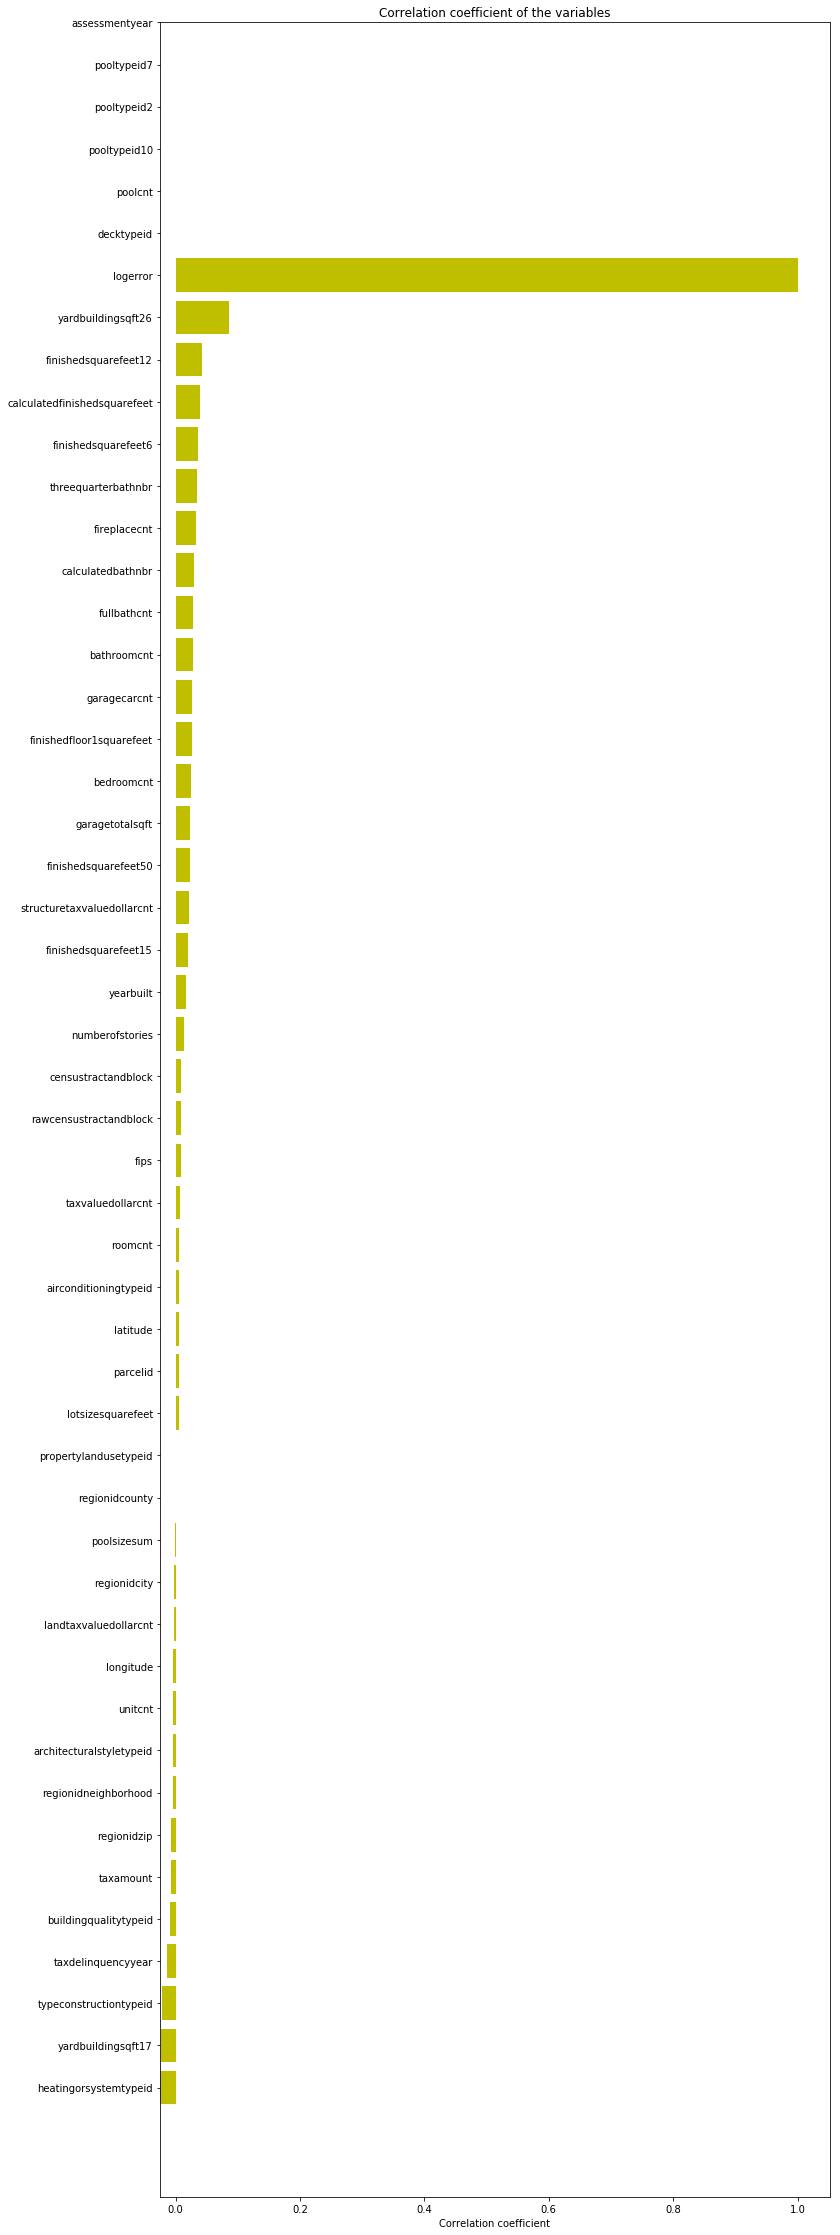

In [6]:
corr = train.corr()

corr_df = pd.DataFrame({'col_labels':list(corr.columns.values), 'corr_values':list(corr.logerror.values)})
corr_df = corr_df.sort_values(by='corr_values')
ind = np.arange(len(corr.columns))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

Bar graph showing correlation of different features with respect to logerror.
Her we can see that features 'assessmentyear', 'pooltypeid7', 'pooltypeid2', 'pooltypeid10', 'poolcnt', 'decktypeid' have no correlation with logerror.

In [7]:
col_no_correlation = ['assessmentyear', 'pooltypeid7', 'pooltypeid2', 'pooltypeid10', 'poolcnt', 'decktypeid']
train = train.drop(col_no_correlation, axis=1)
len(train.columns)

50

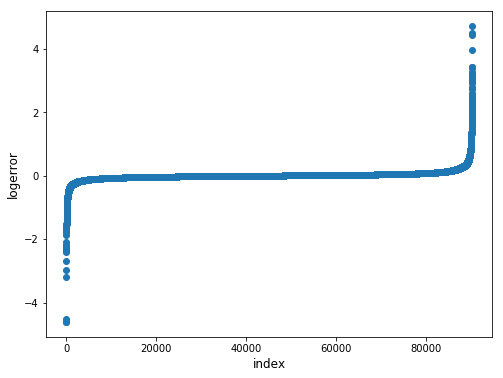

In [8]:
#logerror 
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

Scatter plot of logerror values. We can see that logerror have a continuous graph excepting
some outliers.

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


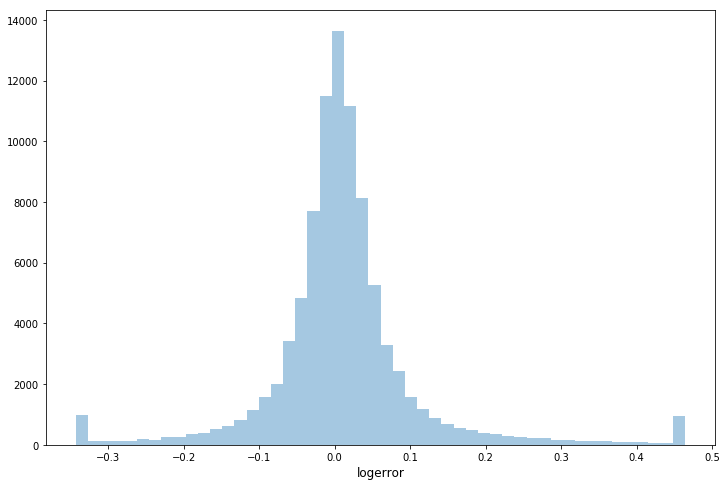

In [9]:
#removing outliers
ulimit = np.percentile(train.logerror.values, 99)
llimit = np.percentile(train.logerror.values, 1)
train['logerror'].ix[train['logerror']>ulimit] = ulimit
train['logerror'].ix[train['logerror']<llimit] = llimit

plt.figure(figsize=(12,8))
sb.distplot(train.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

Distribution plot of logerror as a univariate distribution of observations.

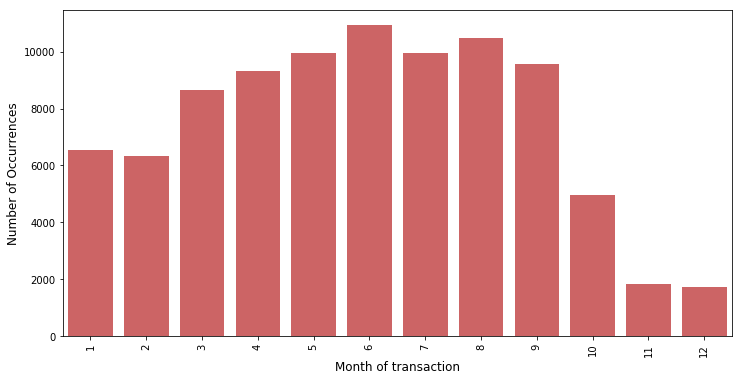

In [10]:
train['transaction_month'] = train['transactiondate'].dt.month

cnt_srs = train['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
sb.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

Plot of count of transactions vs month. It shows that the transactions are low in Nov and Dec.

In [11]:
corr_df_sel = corr_df.ix[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
corr_df_sel

,col_labels,corr_values
20,heatingorsystemtypeid,-0.025018
39,yardbuildingsqft17,-0.023692
37,typeconstructiontypeid,-0.022419
48,taxdelinquencyyear,-0.012996
43,structuretaxvaluedollarcnt,0.022085
13,finishedsquarefeet50,0.023619
19,garagetotalsqft,0.023888
5,bedroomcnt,0.025467
9,finishedfloor1squarefeet,0.026242
18,garagecarcnt,0.026531


Removing columns which have less correlation with logerror

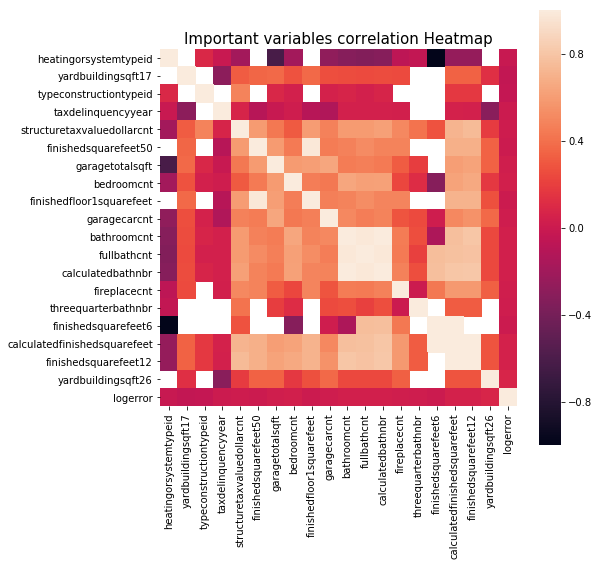

In [12]:
cols_to_use = corr_df_sel.col_labels.tolist()

temp_df = train[cols_to_use]
corrmat = temp_df.corr(method='pearson')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sb.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation Heatmap", fontsize=15)
plt.show()
del corr_df
del corr_df_sel

Heatmap of features after removing columns with less correlation and too many null values.


/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


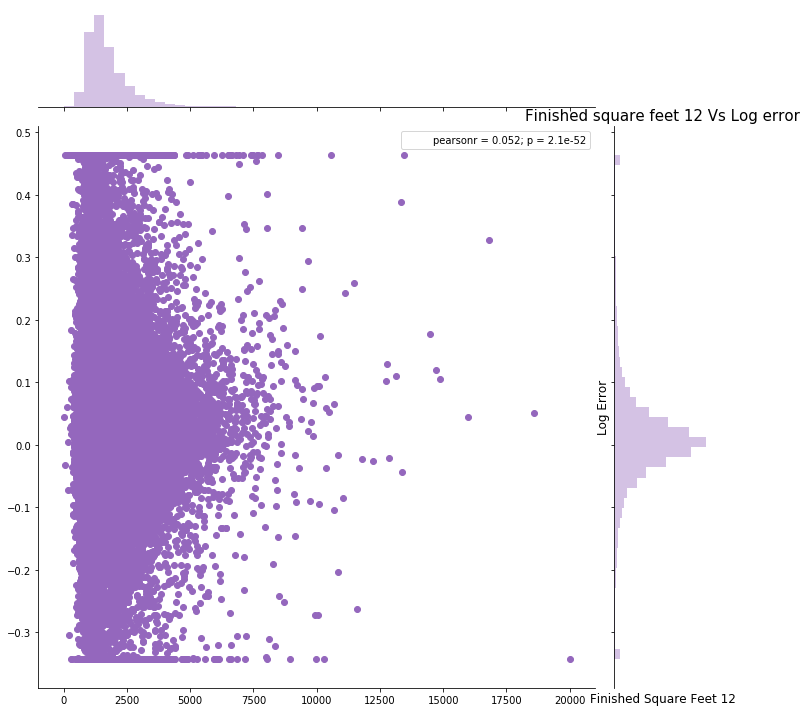

In [12]:
col = "finishedsquarefeet12"
ulimit = np.percentile(train[col].values, 99.5)
llimit = np.percentile(train[col].values, 0.5)
train[col].ix[train[col]>ulimit] = ulimit
train[col].ix[train[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sb.jointplot(x=train.finishedsquarefeet12.values, y=train.logerror.values, size=10, color=color[4])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

Jointplot of finishedsquarefeet12 vs logerror . It shows that as the finishedsquarefeet12 increases logerror also increases.

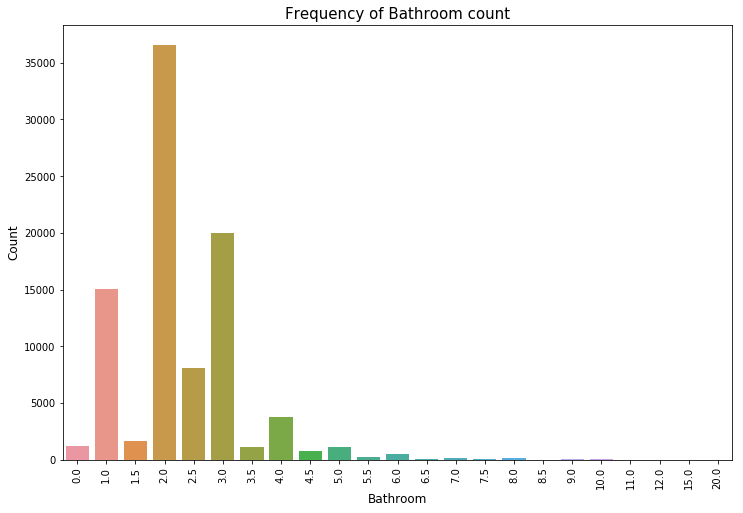

In [14]:
plt.figure(figsize=(12,8))
sb.countplot(x="bathroomcnt", data=train)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

Bar plot of bathrooms vs count in the houses. We can see that most of the houses have 2 bathrooms.

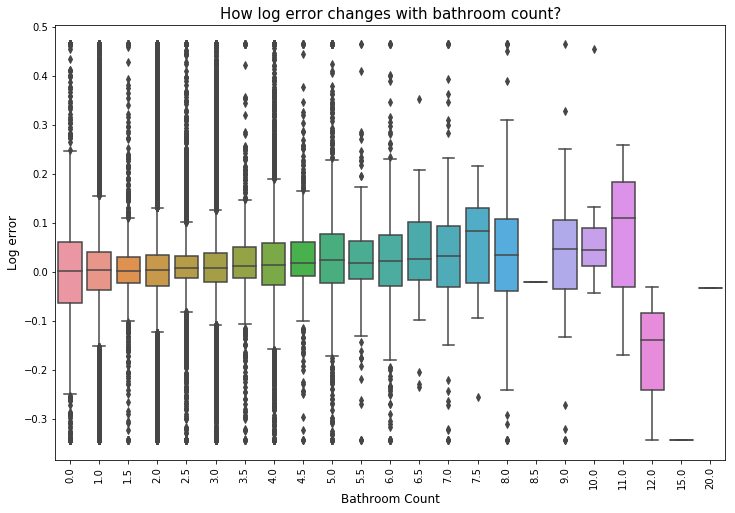

In [15]:
plt.figure(figsize=(12,8))
sb.boxplot(x="bathroomcnt", y="logerror", data=train)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How log error changes with bathroom count?", fontsize=15)
plt.show()

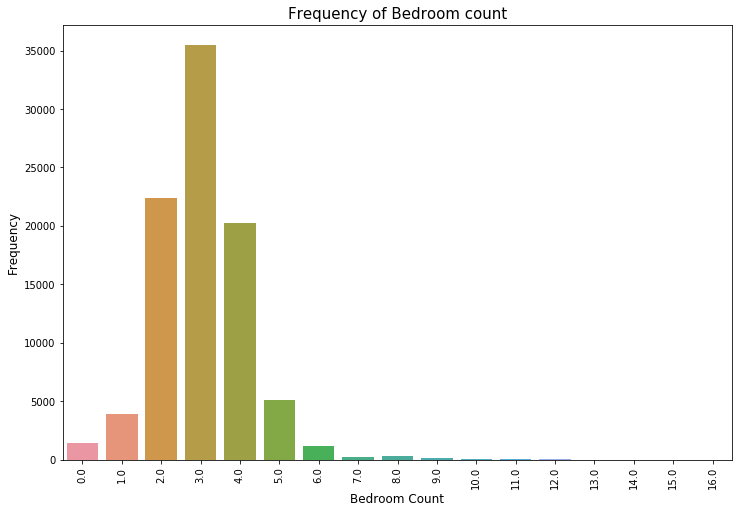

In [16]:
plt.figure(figsize=(12,8))
sb.countplot(x="bedroomcnt", data=train)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

Bar graph for bedroom counts. It shows that most of the houses have 3 bedrooms.

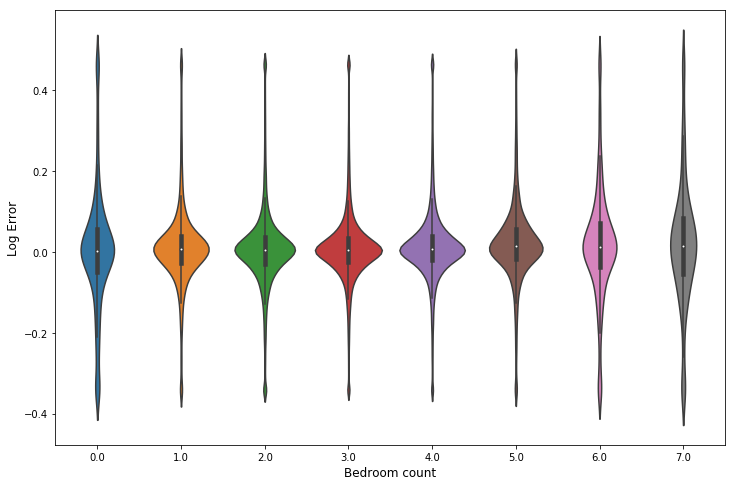

In [17]:
train['bedroomcnt'].ix[train['bedroomcnt']>7] = 7
plt.figure(figsize=(12,8))
sb.violinplot(x='bedroomcnt', y='logerror', data=train)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

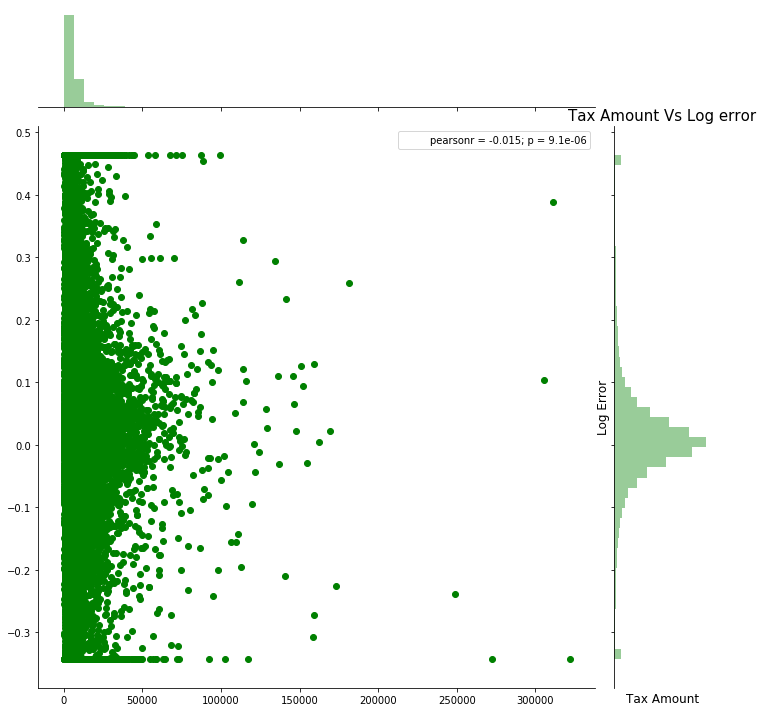

In [13]:
col = "taxamount"
ulimit = np.percentile(train[col].values, 99.5)
llimit = np.percentile(train[col].values, 0.5)
train[col].ix[train[col]>ulimit] = ulimit
train[col].ix[train[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sb.jointplot(x=train['taxamount'].values, y=train['logerror'].values, size=10, color='g')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Tax Amount', fontsize=12)
plt.title("Tax Amount Vs Log error", fontsize=15)
plt.show()

Jointplot of tax amount vs logerror . It shows that as the tax amount of the property increases logerror decreases.

In [19]:
from sklearn.preprocessing import LabelEncoder
for c in train.columns:
        train[c]=train[c].fillna(-1)
        if train[c].dtype == 'object':
            lbl = LabelEncoder()
            lbl.fit(list(train[c].values))
            train[c] = lbl.transform(list(train[c].values))
        

Generating values for object type features using LabelEncoder.

In [20]:
x_train = train.drop(['parcelid', 'logerror','transactiondate'], axis=1)
y_train = train["logerror"].values

In [21]:
from sklearn import model_selection, preprocessing
import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(x_train, y_train, feature_names=x_train.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)
del train
del dtrain
del x_train
del y_train

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Generating model using xgboost.

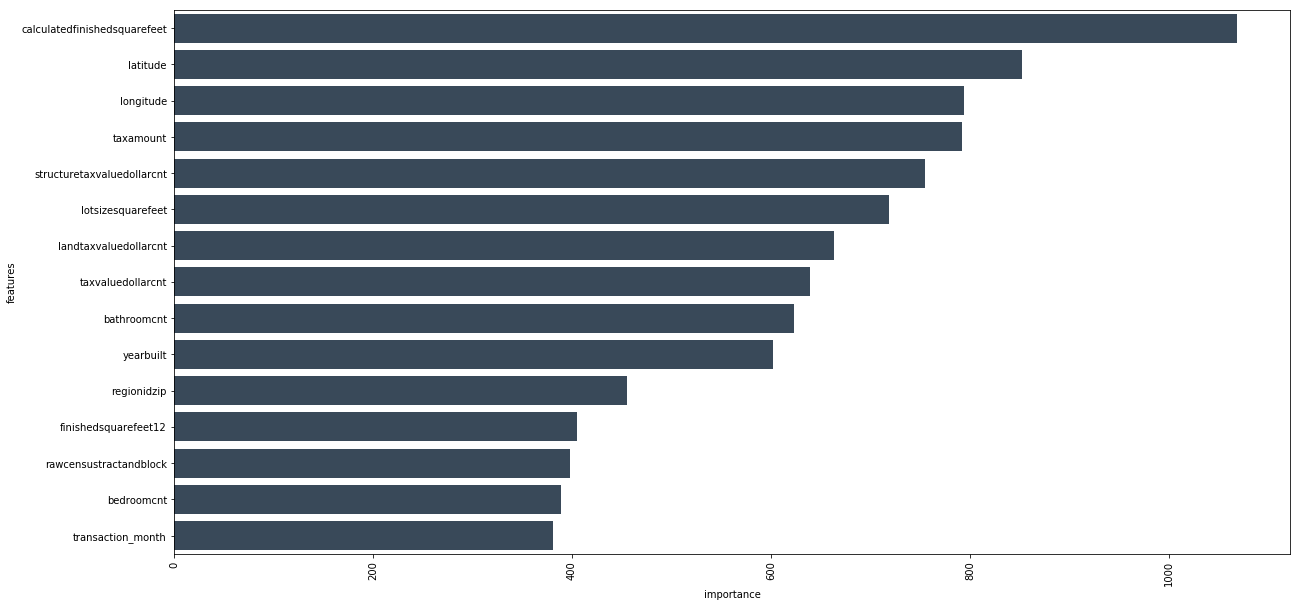

In [22]:
featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=90)
sb.barplot(data=features.head(15),x="importance",y="features",ax=ax,orient="h",color="#34495e")

Bar graph of features against their importance. Here we can see that calculatedfinishedsquarefeet is the most important feature and transaction_month is the least important feature.

In [23]:
# dtrain = xgb.DMatrix(x_train, feature_names=x_train.columns.values)
# ypred = model.predict(dtrain)
# len(ypred)

In [14]:
test = df

In [15]:
test = test.drop(list(no_values.column_name.values), axis=1)
col_no_correlation = ['assessmentyear', 'pooltypeid7', 'pooltypeid2', 'poolcnt', 'decktypeid']
test = test.drop(col_no_correlation, axis=1)


In [16]:
test['transaction_month'] = 10
test['bedroomcnt'].ix[test['bedroomcnt']>7] = 7
col = "taxamount"
ulimit = np.percentile(test[col].values, 99.5)
llimit = np.percentile(test[col].values, 0.5)
test[col].ix[test[col]>ulimit] = ulimit
test[col].ix[test[col]<llimit] = llimit
from sklearn.preprocessing import LabelEncoder
for c in test.columns:
        test[c]=test[c].fillna(-1)
        if test[c].dtype == 'object':
            lbl = LabelEncoder()
            lbl.fit(list(test[c].values))
            test[c] = lbl.transform(list(test[c].values))
        

test = test.drop(['parcelid'], axis=1)
print(len(test.columns))

49


Creating test data similar to train data.

In [17]:
del df

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [30]:
dtest = xgb.DMatrix(test, feature_names=test.columns.values)
ypred = model.predict(dtest)
len(ypred)

2985217

In [31]:
ypred[0:20]

array([ 0.22084498,  0.04687124,  0.19935635,  0.13292161,  0.03547287,
        0.04017651,  0.00351769,  0.05327559,  0.18383884,  0.02149966,
        0.04957789,  0.22759861, -0.03210151,  0.16780823,  0.18467328,
        0.14979279,  0.13750124,  0.03130785,  0.11421964,  0.03007635], dtype=float32)

In [34]:
from datetime import datetime
pre = ypred
sub = pd.read_csv('../data/sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = pre
sub[0:20]

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0.220845,0.220845,0.220845,0.220845,0.220845,0.220845
1,10759547,0.046871,0.046871,0.046871,0.046871,0.046871,0.046871
2,10843547,0.199356,0.199356,0.199356,0.199356,0.199356,0.199356
3,10859147,0.132922,0.132922,0.132922,0.132922,0.132922,0.132922
4,10879947,0.035473,0.035473,0.035473,0.035473,0.035473,0.035473
5,10898347,0.040177,0.040177,0.040177,0.040177,0.040177,0.040177
6,10933547,0.003518,0.003518,0.003518,0.003518,0.003518,0.003518
7,10940747,0.053276,0.053276,0.053276,0.053276,0.053276,0.053276
8,10954547,0.183839,0.183839,0.183839,0.183839,0.183839,0.183839
9,10976347,0.021500,0.021500,0.021500,0.021500,0.021500,0.021500


In [35]:
sub.to_csv('../data/submit.csv', index=False,  float_format='%.4f')

Final score got from kaggle 0.0717260